In [134]:
import sys
import numpy as np
import os
import cv2
import logging
from image_utils import standardize
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as Fu
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
from unet_meli import UNet,weights_init
# from unet_val import UNet
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from shapeSorter import SimpleSegmentationDataset
from IOU_computations import *
from random import randint
import time

In [135]:
%matplotlib notebook

In [136]:
!gpustat

tethys  Sat Apr 14 12:07:03 2018
[0] GeForce GTX 1080 Ti | 45'C,   0 % |  1707 / 11170 MB | s161362(1697M)
[1] GeForce GTX 1080 Ti | 29'C,  23 % |  2489 / 11172 MB | jjalma(2479M)


In [137]:
##########
GLOBAL_PATH='MODEL_SHAPE_PYTORCH_MELI/'
##########

if not os.path.exists(GLOBAL_PATH):
            os.makedirs(GLOBAL_PATH)
        
#############
PATH_TRAINING='TRAINING/'
PATH_VALIDATION='VALIDATION/'
PATH_TEST='TEST/'

PATH_INPUT='INPUT/'
PATH_OUTPUT='OUTPUT/'
##############

        
INPUT_CHANNELS=3
NB_CLASSES=3

SIZE_PATCH=120
##############
MODEL_PATH_SAVE=GLOBAL_PATH+'pytorch_shape'
MODEL_PATH_RESTORE=''
TEST_SAVE=GLOBAL_PATH+'TEST_SAVE/'
if not os.path.exists(TEST_SAVE):
            os.makedirs(TEST_SAVE)
        
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

##############

REC_SAVE=2000#2000
DROPOUT=0.1#0.9
DEFAULT_BATCH_SIZE = 8#8
DEFAULT_EPOCHS = 1#300
DEFAULT_VALID=10#100
DISPLAY_STEP=100#100

###############
DEFAULT_LAYERS=3
DEFAULT_FEATURES_ROOT=32
DEFAULT_FILTERS_SIZE=3
DEFAULT_LR=0.0001

####### TMP folder for IOU

TMP_IOU=TEST_SAVE+'TMP_IOU/'
if not os.path.exists(TMP_IOU):
            os.makedirs(TMP_IOU)

In [138]:
 class Trainer(object):
    """
    Trains a unet instance
    
    :param net: the unet instance to train
    :param batch_size: size of training batch
    :param lr: learning rate
    """
    def __init__(self, net, batch_size=10, lr=0.0001,nb_classes=4):
        self.net = net
        self.batch_size = batch_size
        self.lr = lr
        self.nb_classes=nb_classes
    def _initialize(self, prediction_path):
        
        self.optimizer = optim.Adam(self.net.parameters(),lr=self.lr)
        self.prediction_path = prediction_path
        
    
    def train(self, save_path='', restore_path='',  epochs=3, dropout=0.9, display_step=1, validation_batch_size=30,rec_save=1, prediction_path = '',data_aug=None):
        """
        Lauches the training process
        

        :param save_path: path where to store checkpoints
        :param restore_path: path where is the model to restore is stored
        :param epochs: number of epochs
        :param dropout: dropout probability
        :param display_step: number of steps till outputting stats
        :param restore: Flag if previous model should be restored 
        :param prediction_path: path where to save predictions on each epoch
        """
        ###Visualize Training  loss and lr
        
        
        
        fig,axs =plt.subplots(1, 2,figsize=(6,3))

        axs[0].set_ylim(0,0.001)
        axs[0].set_title('Loss train')
        axs[1].set_ylim(0,1)
        axs[0].set_title('Learning rate')
        ###Tune Learning rate
        reduce_lr_steps = [1,5, 10, 100,200]
        
        if epochs == 0:
            return save_path
        if save_path=='':
            return 'Specify a path where to store the Model'
        self._initialize(prediction_path)
            
        
          
        
        val_generator=SimpleSegmentationDataset(SIZE_PATCH, 3, alpha =1.0,virtual_size=30)
        val_loader = DataLoader(val_generator, batch_size=validation_batch_size,shuffle=True, num_workers=4)
        
        RBD=randint(0,int(val_loader.__len__())-1)
        self.store_init(val_loader,"_init",RBD)
        
        train_generator=SimpleSegmentationDataset(SIZE_PATCH, 3, alpha =1.0,virtual_size=4960)#4960
        train_loader = DataLoader(train_generator, batch_size=self.batch_size,shuffle=True, num_workers=4)
        
#         val_generator=train_generator
#         val_loader=train_loader
#         RBD=randint(0,int(val_loader.__len__())-1)
#         self.store_init(val_loader,"_init",RBD)
        lr_train=np.zeros(train_loader.__len__()*epochs)
        if restore_path=='':
            loss_train,file_train,loss_verif,file_verif,IOU_verif,IOU_file_verif,IOU_acc_verif,IOU_acc_file_verif,f1_IOU_verif,f1_IOU_file_verif=save_metrics(epochs,train_loader.__len__(),TEST_SAVE,'w')
            
            print('Model trained from scratch')
        else:
            loss_train,file_train,loss_verif,file_verif,IOU_verif,IOU_file_verif,IOU_acc_verif,IOU_acc_file_verif,f1_IOU_verif,f1_IOU_file_verif=save_metrics(epochs,train_loader.__len__(),TEST_SAVE,'a')
            self.net.load_state_dict(torch.load(restore_path))
            print('Model loaded from {}'.format(restore_path))

        logging.info("Start optimization")

        counter=0
        
        for epoch in range(epochs):
            if epoch in reduce_lr_steps:
                self.lr = self.lr * 0.3
                self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.lr)
            
            total_loss = 0
            error_tot=0
            train_loader = DataLoader(train_generator, batch_size=self.batch_size,shuffle=True, num_workers=4)
            for i_batch,sample in enumerate(train_loader):
                
                
                x=sample['input']
                y=sample['groundtruth']
#                 batch_x=x
                batch_x=standardize(x)
                batch_y=y
        
                X = Variable(batch_x.float())
                X=X.permute(0,3,1,2).cuda()  
                Y = Variable(batch_y.float())
                Y=Y.cuda() 
 
                probs=predict(self.net,X,self.optimizer)
                loss=criterion(Y,probs)
                loss.backward()
                self.optimizer.step()
                total_loss+=loss.data[0]
                loss_train[counter]=loss.data[0]
                lr_train[counter]=self.lr
                file_train.write(str(loss_train[counter])+'\n')
                counter+=1
                
                if i_batch % display_step == 0:
                    self.output_training_stats(i_batch,X,Y)
                    draw_update(len(loss_train),loss_train,lr_train,fig,axs)
                    time.sleep(1)
                if counter % rec_save == 0:
                    torch.save(self.net.state_dict(),save_path + 'CP{}.pth'.format(counter))
                    print('Checkpoint {} saved !'.format(counter))

            logging.info(" Training {:}, Minibatch Loss= {:.4f}".format("epoch_%s"%epoch,total_loss/train_loader.__len__() ))
            error_rate_v,loss_v,iou_v,iou_acc_v,f1_v=self.store_validation(val_loader, "epoch_%s"%epoch,RBD,save_patches=False)
            IOU_verif[epoch]=iou_v
            IOU_acc_verif[epoch]=iou_acc_v
            f1_IOU_verif[epoch]=f1_v
            loss_verif[epoch]=loss_v
            
            IOU_file_verif.write(str(IOU_verif[epoch])+'\n')
            IOU_acc_file_verif.write(str(IOU_acc_verif[epoch])+'\n')
            f1_IOU_file_verif.write(str(f1_IOU_verif[epoch])+'\n')
            file_verif.write(str(loss_verif[epoch])+'\n')
            
        error_rate_v,loss_v,iou_v,iou_acc_v,f1_v=self.store_validation(val_loader, "epoch_%s"%epoch,RBD,save_patches=True)
        time.sleep(1)
        plt.close(fig)
        return save_path, loss_train,loss_verif,IOU_verif,IOU_acc_verif,f1_IOU_verif      
    
    def output_training_stats(self, step, batch_x, batch_y):
        # Calculate batch loss and accuracy

        predictions=predict(self.net,batch_x,self.optimizer)
        loss=criterion(batch_y,predictions)
        loss=loss.data[0]
        predictions=predictions.data.cpu().numpy()
        groundtruth=batch_y.data.cpu().numpy()#np.asarray(batch_y)
        logging.info("Iter {:}, Minibatch Loss= {:.4f}, Minibatch error= {:.1f}%".format(step,loss,error_rate(predictions, groundtruth)))
        
        
        
        
    def store_init(self,val_loader,name,random_batch_display,*,save_patches=True):
        loss_v=0
        error_rate_v=0

        for i_batch,sample in enumerate(val_loader):
            x=sample['input']
            y=sample['groundtruth']
#             batch_x=x
            batch_x=standardize(x)
            
            X = Variable(batch_x.float())
            X=X.permute(0,3,1,2).cuda()  
            Y = Variable(y.float())
            Y=Y.cuda()  
    
            
            probs=predict(self.net,X,self.optimizer)
            loss=criterion(Y,probs)
            loss_v+=loss.data[0]
            prediction_v=probs.data.cpu().numpy()
            groundtruth=np.asarray(y)
            error_rate_v+=error_rate(prediction_v,groundtruth)
            if i_batch==random_batch_display:
                
                batch_x=np.asarray(batch_x)
#                 pansharp=np.stack((batch_x[:,:,:,5],batch_x[:,:,:,3],batch_x[:,:,:,2]),axis=3)
                plot_summary(prediction_v,groundtruth,batch_x,name,self.prediction_path,save_patches)

    
                         
        loss_v/=val_loader.__len__()   
        error_rate_v/=val_loader.__len__()  
        logging.info("Verification  loss= {:.4f},error= {:.1f}%".format(loss_v,error_rate_v))
        
    
    def store_validation(self,val_loader, name,random_batch_display,*,save_patches=True):
        loss_v=0
        iou_v=0
        iou_acc_v=0
        f1_v=0
        error_rate_v=0

        for i_batch,sample in enumerate(val_loader):
            
            x=sample['input']
            y=sample['groundtruth']
#             batch_x=x
            batch_x=standardize(x)
    
            X = Variable(batch_x.float())
            X=X.permute(0,3,1,2).cuda()  
            Y = Variable(y.float())
            Y=Y.cuda()  
            
            probs=predict(self.net,X,self.optimizer)
            loss=criterion(Y,probs)
            loss_v+=loss.data[0]
            
            prediction_v=probs.data.cpu().numpy()
            groundtruth=np.asarray(y)
            iou_acc,f1,iou=predict_score_batch(TMP_IOU,np.argmax(groundtruth,3),np.argmax(prediction_v,3))
            iou_acc_v+=iou_acc
            iou_v+=iou
            f1_v+=f1
            error_rate_v+=error_rate(prediction_v,groundtruth)
            if i_batch==random_batch_display:
                
                batch_x=np.asarray(batch_x)
#                 pansharp=np.stack((batch_x[:,:,:,5],batch_x[:,:,:,3],batch_x[:,:,:,2]),axis=3)
                plot_summary(prediction_v,groundtruth,batch_x,name,self.prediction_path,save_patches)
            

        loss_v/=val_loader.__len__()   
        iou_v/=val_loader.__len__()  
        iou_acc_v/=val_loader.__len__()  
        f1_v/=val_loader.__len__()  
        error_rate_v/=val_loader.__len__()  

        logging.info("Verification  loss= {:.4f},error rate= {:.1f}%, IOU = {:.4f}, IOU Precision = {:.4f}%, F1 IOU= {:.4f}%".format(loss_v,error_rate_v,iou_v,iou_acc_v,f1_v))


        return error_rate_v,loss_v,iou_v,iou_acc_v,f1_v

In [139]:
loss_fn=nn.CrossEntropyLoss()

def criterion(y,y_):

    
#     y = y.permute(0,2,3,1).contiguous()
#     y = y.view(-1,y.size()[-1])
#     y = y.max(-1)[1]
    
#     y_ = y_.permute(0,2,3,1).contiguous()
#     y_ = y_.view(-1,y.size()[-1])
    
#     return loss_fn(y_, y)#.mean()
    
    y = y.contiguous().view(-1,y.size()[-1])
    y_ = y_.contiguous().view(-1,y.size()[-1])
    y = y.max(-1)[1]
    loss = loss_fn( y_,y)
    
    return loss
    
def predict(net,batch_x,optimizer):
    
    
    optimizer.zero_grad()
    logits=net.forward(batch_x) 
    probs=logits.permute(0,2,3,1)
    return probs

    
    
    
#     loss=Fu.binary_cross_entropy_with_logits(logits,Y)
#     probs = Fu.softmax(logits,dim=1)
        
    


def save_metrics(epochs,training_len,prediction_path,mode):
    #STORE loss for ANALYSIS
    loss_train=np.zeros(epochs*training_len)
    file_train = open(prediction_path+'loss_train.txt',mode) 
    loss_verif=np.zeros(epochs)
    file_verif = open(prediction_path+'loss_verif.txt',mode) 
    #STORE IOU for ANALYSIS
    IOU_verif=np.zeros(epochs)
    IOU_file_verif = open(prediction_path+'iou_verif.txt',mode)
    #STORE IOU_ACC for ANALYSIS
    IOU_acc_verif=np.zeros(epochs)
    IOU_acc_file_verif = open(prediction_path+'iou_acc_verif.txt',mode)
    #STORE f1_IOU for ANALYSIS
    f1_IOU_verif=np.zeros(epochs)
    f1_IOU_file_verif = open(prediction_path+'f1_iou_verif.txt',mode) 
    
    return loss_train,file_train,loss_verif,file_verif,IOU_verif,IOU_file_verif,IOU_acc_verif,IOU_acc_file_verif,f1_IOU_verif,f1_IOU_file_verif
def error_rate(predictions, labels):
    """
    Return the error rate based on dense predictions and 1-hot labels.
    """

    return 100.0 - (
        100.0 *
        np.sum(np.argmax(predictions, 3) == np.argmax(labels, 3)) /
        (predictions.shape[0]*predictions.shape[1]*predictions.shape[2]))
def plot_summary(predictions,labels,pansharp,epoch,prediction_path,save_patches):

    
    fig,axs=plt.subplots(3, len(pansharp),figsize=(3*len(pansharp),9))
    #figsize=(8*len(pansharp),24)
   
    labels=np.argmax(labels, 3) 
    logits=np.argmax(predictions, 3)

    

    for i in range(len(pansharp)):
        cax1=axs[0,i].imshow(pansharp[i])
#         fig.colorbar(cax1,ax=axs[0,i])

        cax2=axs[1,i].imshow(labels[i])
#         fig.colorbar(cax2,ax=axs[1,i])

        cax3=axs[2,i].imshow(logits[i])
#         fig.colorbar(cax3,ax=axs[2,i])

        
        if save_patches:

            plt.imsave(prediction_path+epoch+'_Panchro_'+str(i)+'.jpg',pansharp[i]/(np.amax(pansharp[i])))
            plt.imsave(prediction_path+epoch+'_Groundtruth_'+str(i)+'.jpg',labels[i])
            plt.imsave(prediction_path+epoch+'_Predictions_'+str(i)+'.jpg',logits[i])
#     axs[0,0].set_title(epoch+' Pansharpened ', fontsize='large')
#     axs[1,0].set_title(epoch+' Groundtruth ', fontsize='large')
#     axs[2,0].set_title(epoch+' Predictions ', fontsize='large')
#     plt.subplots_adjust()
    fig.canvas.draw()
    time.sleep(1)
    plt.close(fig)

#     plt.show()
    
def draw_update(global_step,loss,lr,fig,axs):

    ite=np.arange(global_step)
    axs[0].clear()
    axs[1].clear()
    line1, = axs[0].plot(ite, loss, 'r-') 
    line2, = axs[1].plot(ite, lr, 'b-') 
    fig.canvas.draw()

<IPython.core.display.Javascript object>


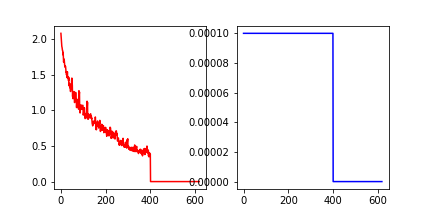

<IPython.core.display.Javascript object>


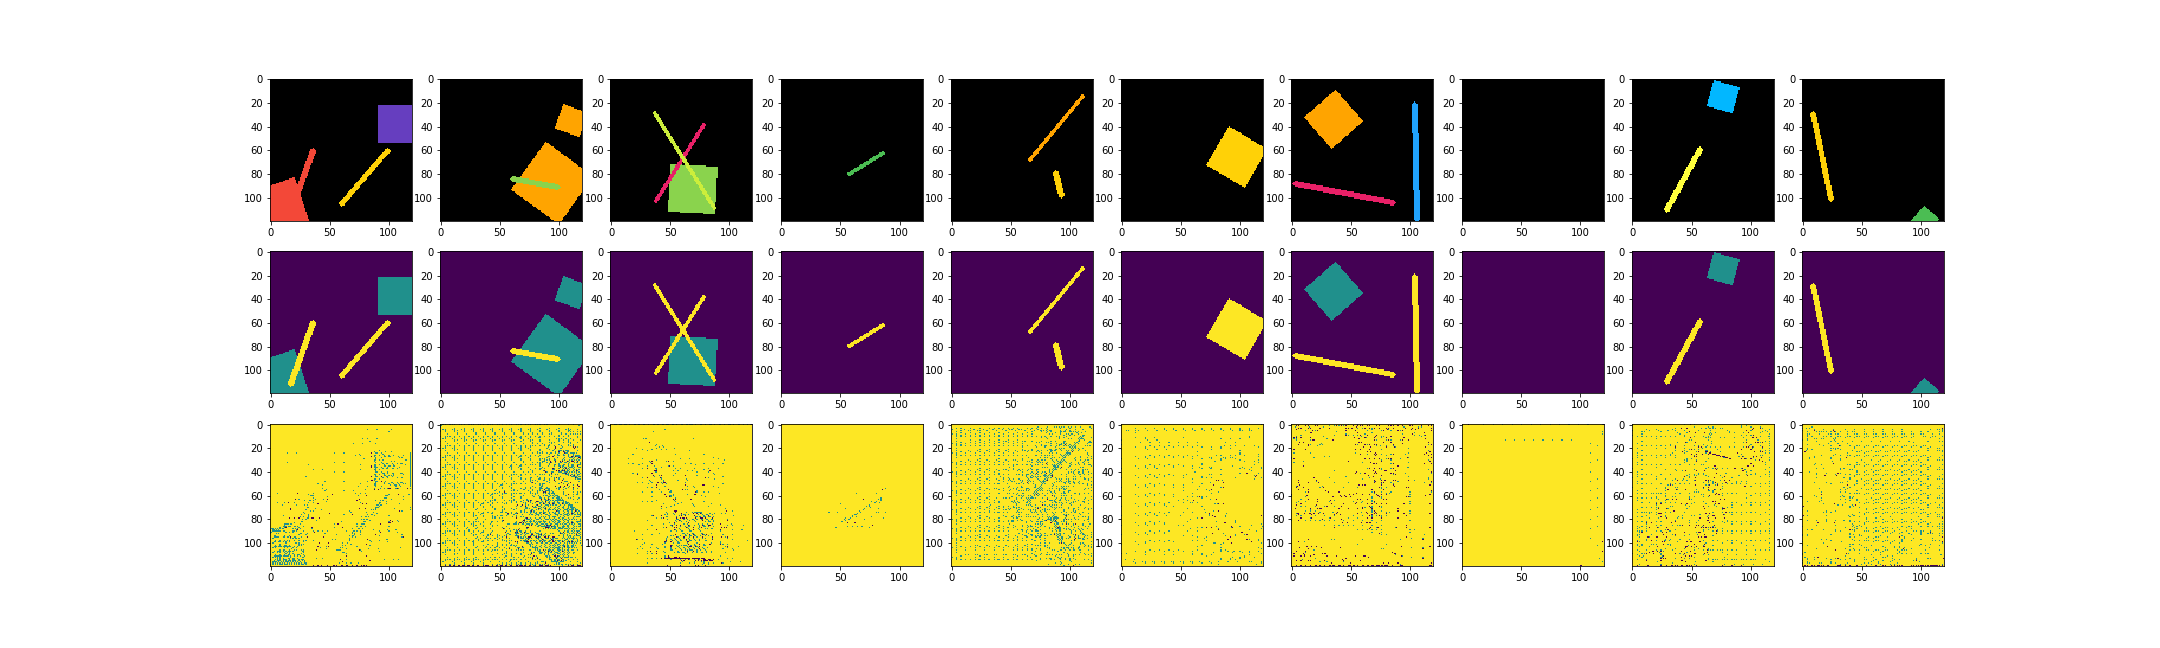

2018-04-14 12:07:08,398 Verification  loss= 2.0464,error= 95.7%
2018-04-14 12:07:08,478 Start optimization


Model trained from scratch


2018-04-14 12:07:08,780 Iter 0, Minibatch Loss= 2.0475, Minibatch error= 96.3%
2018-04-14 12:07:14,086 Iter 100, Minibatch Loss= 0.9226, Minibatch error= 37.3%
2018-04-14 12:07:19,326 Iter 200, Minibatch Loss= 0.7314, Minibatch error= 9.0%
2018-04-14 12:07:24,662 Iter 300, Minibatch Loss= 0.5032, Minibatch error= 4.4%
2018-04-14 12:07:30,015 Iter 400, Minibatch Loss= 0.3740, Minibatch error= 2.9%


In [ ]:
if __name__ == '__main__':

    
    model=UNet(INPUT_CHANNELS,NB_CLASSES,DEFAULT_LAYERS,DEFAULT_FEATURES_ROOT,DROPOUT)
    model.apply(weights_init)
    model.cuda()
    cudnn.benchmark = True
    trainer=Trainer(model,DEFAULT_BATCH_SIZE,DEFAULT_LR,NB_CLASSES)
    save_path,loss_train,loss_verif,iou_verif,iou_acc_verif,f1_iou_verif=trainer.train(  MODEL_PATH_SAVE, MODEL_PATH_RESTORE,DEFAULT_EPOCHS,DROPOUT, DISPLAY_STEP, DEFAULT_VALID,REC_SAVE, TEST_SAVE)
    print('Last model saved is %s: '%save_path)
    #SAVE loss
    plt.subplot(1,4,1)
    plt.title('Plot Loss', fontsize=20)
    ite = np.arange(0,len(loss_train),1)
    epo=np.arange(int(len(loss_train)/DEFAULT_EPOCHS)-1,len(loss_train),int(len(loss_train)/DEFAULT_EPOCHS))
    plt.plot(ite,loss_train,'b',epo,loss_verif,'g')
    plt.ylabel('Loss')

    
     #SAVE IOU
    plt.subplot(1,4,2)
    plt.title('Plot IOU', fontsize=20)
    epo=np.arange(int(len(loss_train)/DEFAULT_EPOCHS)-1,len(loss_train),int(len(loss_train)/DEFAULT_EPOCHS))
    plt.plot(epo,iou_verif,'g')
    plt.ylabel('IOU in %')

    
    #SAVE IOU  acc
    plt.subplot(1,4,3)
    plt.title('Plot IOU Accuracy', fontsize=20)
    epo=np.arange(int(len(loss_train)/DEFAULT_EPOCHS)-1,len(loss_train),int(len(loss_train)/DEFAULT_EPOCHS))
    plt.plot(epo,iou_acc_verif,'g')
    plt.ylabel('IOU Accuracy in %')


    
     #SAVE f1 IOU
    plt.subplot(1,4,4)
    plt.title('Plot f1 IOU', fontsize=20)
    epo=np.arange(int(len(loss_train)/DEFAULT_EPOCHS)-1,len(loss_train),int(len(loss_train)/DEFAULT_EPOCHS))
    plt.plot(epo,f1_iou_verif,'g')
    plt.ylabel('f1 IOU in %')
    plt.show()
